# Deep Reinforcement Learning for Portfolio Optimization - MLP Architecture


This experiement demonstrates the application of deep reinforcement learning (DRL) techniques for portfolio optimization.

- Policy network architecture: **MLP backbone**
- Compares `A2C`, `PPO`, `SAC`, `DDPG`, `TD3` all with simple MLPs


## Dependencies


In [9]:
# ! pip install pandas numpy matplotlib \
#                stable-baselines3 \
#                PyPortfolioOpt \
#                pandas_market_calendars quantstats gymnasium \
#                git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

from tqdm.auto import tqdm

import torch

from stable_baselines3 import A2C, PPO, SAC, DDPG, TD3
from stable_baselines3.common.noise import NormalActionNoise

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from finrl.plot import backtest_stats, get_daily_return, get_baseline, backtest_plot

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [11]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

%matplotlib inline

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [13]:
experiment_name = "mlp_5_models_report"
results_dir = f"results/models/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

## Data loading and pre-processing


Define training and trading/test periods


In [14]:
start_date = "2015-01-01"
end_date = (datetime.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # Yesterday

trade_period = 2  # 2 years for testing
train_period = 10  # 10 years for training

train_end_date = (
    datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=trade_period * 365)
).strftime("%Y-%m-%d")
train_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") - timedelta(days=train_period * 365)
).strftime("%Y-%m-%d")
test_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") + timedelta(days=1)
).strftime("%Y-%m-%d")

train_dates = (train_start_date, train_end_date)
test_dates = (test_start_date, end_date)

print(f"Training period: {train_dates}")
print(f"Testing period: {test_dates}")

Training period: ('2013-05-06', '2023-05-04')
Testing period: ('2023-05-05', '2025-05-03')


- Fetch historical stock data for a given list of tickers within a specified date range.
- We use the DOW_30_TICKER stocks
- The data includes `date`, `close`, `high`, `low`, `open`, `volume`, and `tic` (ticker symbol).


In [15]:
def download_data(tickers, start_date, end_date):
    print(f"Downloading {start_date} → {end_date}")
    return YahooDownloader(
        start_date=start_date, end_date=end_date, ticker_list=tickers
    ).fetch_data()


df = download_data(config_tickers.DOW_30_TICKER, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (76911, 8)


---

We apply feature engineering to the dataset of stock data:

- Add technical indicators (e.g., moving averages, RSI).
- Calculate turbulence indicators, which measure market volatility.

This Enhance the dataset with features that are critical for modeling market dynamics and making informed trading decisions.


In [16]:
def preprocess_data(df):
    fe = FeatureEngineer(use_technical_indicator=True, use_turbulence=True)
    return fe.preprocess_data(df)


df_feat = preprocess_data(df)

# TODO: Normalise the data??

Successfully added technical indicators
Successfully added turbulence index


## Covariance & Returns for State


- Calculate the rolling covariance matrices and daily returns for the given dataset of stock prices.
- This prepares the state representation (the state of the portfolio) for the RL models in the RL environments for portfolio optimization.
- The **rolling covariance matrices** (`cov_list`) capture the relationships between asset returns, while the daily returns (`return_list`) provide information about recent price movements.
- These metrics are critical for modeling the dynamics of the financial market and making informed trading decisions.


In [20]:
def compute_covariance_and_returns(df_feat, lookback=252):
    df_sorted = df_feat.sort_values(["date", "tic"], ignore_index=True)
    df_sorted.index = df_sorted.date.factorize()[0]
    cov_list, return_list = [], []

    dates = df_sorted.date.unique()
    for i in tqdm(range(lookback, len(dates)), desc="Computing covariance and returns"):
        win = df_sorted.loc[i - lookback : i]
        pm = win.pivot_table(index="date", columns="tic", values="close")
        rm = pm.pct_change().dropna()
        cov_list.append(rm.cov().values)
        return_list.append(rm)
    df_cov = pd.DataFrame(
        {"date": dates[lookback:], "cov_list": cov_list, "return_list": return_list}
    )

    return pd.merge(df_feat, df_cov, on="date", how="left").dropna(subset=["cov_list"])


df_all = compute_covariance_and_returns(df_feat)

Computing covariance and returns:   0%|          | 0/2347 [00:00<?, ?it/s]

## Train/Trade split


In [21]:
def split_data(df_all, train_dates, test_dates):
    train = data_split(df_all, *train_dates)
    test = data_split(df_all, *test_dates)
    return train, test


train, test = split_data(df_all, train_dates, test_dates)

## Environment setup


- Create instances of the StockPortfolioEnv class for both training and testing datasets.
- It also wrap the training environment for use with Stable-Baselines3 (SB3).


In [22]:
def configure_environment(train, test, fe):
    stock_dim = len(train.tic.unique())
    env_kwargs = dict(
        stock_dim=stock_dim,  # Number of unique stocks
        hmax=100,  # Maximum number of shares that can be traded
        initial_amount=1e6,  # Initial portfolio value (e.g., $1,000,000)
        transaction_cost_pct=0.001,  # Transaction cost as a percentage (e.g., 0.1%)
        reward_scaling=1e-4,  # Scaling factor for rewards
        state_space=stock_dim,  # State space dimension (equal to stock_dim)
        action_space=stock_dim,  # Action space dimension (equal to stock_dim)
        tech_indicator_list=fe.tech_indicator_list,  # List of technical indicators
    )

    # create the two StockPortfolioEnv objects
    raw_train_env = StockPortfolioEnv(df=train, **env_kwargs)
    raw_test_env = StockPortfolioEnv(df=test, **env_kwargs)

    # Wrap the *training* env for SB3
    env_train_sb3, _ = raw_train_env.get_sb_env()

    return env_train_sb3, raw_train_env, raw_test_env, env_kwargs


env_train_sb3, raw_train_env, raw_test_env, env_kwargs = configure_environment(
    train, test, FeatureEngineer()
)

## Training


- We define the configuration for various RL models to be trained in the portfolio optimization environment.
- The training environment (`env_train_sb3`) is wrapped for use with Stable-Baselines3 (SB3).
- The SB3 environment provides the `state` and `action space` dimensions needed for configuring the models.


In [23]:
def prepare_models(env_train_sb3):
    model_configs = [
        (A2C, "A2C", {}),
        (PPO, "PPO", {}),
        (SAC, "SAC", {}),
        (DDPG, "DDPG", {}),
        (TD3, "TD3", {}),
    ]
    return model_configs


model_configs = prepare_models(env_train_sb3)

Train multiple reinforcement learning (RL) models using the specified training environment and configuration.


In [ ]:
def train_models(env_train_sb3, model_configs, save_dir, timesteps=200_000):
    models, training_times = {}, {}

    for cls, name, kwargs in model_configs:
        print(f"Training {name}...")
        start_time = time.time()
        model = cls("MlpPolicy", env_train_sb3, verbose=0, **kwargs)
        model.learn(total_timesteps=timesteps)
        end_time = time.time()
        training_times[name] = (end_time - start_time) / 60
        models[name] = model
        model.save(f"{save_dir}/{name}_mlp_model")
        print(f"{name} training completed in {training_times[name]:.2f} minutes.")

    return models, training_times

In [ ]:
models, training_times = train_models(
    env_train_sb3, model_configs, results_dir, timesteps=250_000
)

Training A2C...
begin_total_asset:1000000.0
end_total_asset:2681469.664718087
Sharpe:  0.8198198005958848
begin_total_asset:1000000.0
end_total_asset:2669000.716489017
Sharpe:  0.8137234599992093
begin_total_asset:1000000.0
end_total_asset:2623401.55192771
Sharpe:  0.7924713486377879
begin_total_asset:1000000.0
end_total_asset:2806788.5127160144
Sharpe:  0.8423162271281762
begin_total_asset:1000000.0
end_total_asset:2791825.1507450533
Sharpe:  0.8382984872942474
begin_total_asset:1000000.0
end_total_asset:2629858.7833599434
Sharpe:  0.7899048360639006
begin_total_asset:1000000.0
end_total_asset:2747764.4573506666
Sharpe:  0.8198835241495557
begin_total_asset:1000000.0
end_total_asset:2604368.4053025353
Sharpe:  0.7830753222976566
begin_total_asset:1000000.0
end_total_asset:2698201.4473208915
Sharpe:  0.8107722144868578
begin_total_asset:1000000.0
end_total_asset:2593426.622990027
Sharpe:  0.784834856069963
begin_total_asset:1000000.0
end_total_asset:2640979.7858722485
Sharpe:  0.790284

In [ ]:
training_times_df = pd.DataFrame(
    list(training_times.items()), columns=["model", "training_duration (min)"]
)

training_times_df.to_csv(f"{results_dir}/training_times.csv", index=False)

print("Training summary:")
display(training_times_df)

Training summary:


model  training_duration (min)
0   A2C                 0.000662
1   PPO                 0.030089
2   SAC                 0.000326
3  DDPG                 0.000341
4   TD3                 0.000399

## Model loading


Load the trained models from memory for analysis without the need for time consuming retraining


In [ ]:
def load_models(model_configs, results_dir):
    models = {}
    for _, name, _ in model_configs:
        model_path = f"{results_dir}/{name}_mlp_model.zip"
        if os.path.exists(model_path):
            print(f"Loading saved model for {name}...")
            models[name] = globals()[name].load(model_path)
        else:
            print(f"No saved model found for {name}.")
    return models


# models = load_models(model_configs, results_dir)

## Backtesting


- Evaluates the performance of the RL models/algorithms in a trading environment.
- We do this by calculating the **cumulative portfolio value** and **performance metrics** for each RL model.


In [ ]:
def backtest_rl_strategies(models, raw_env, env_kwargs):
    results = {}
    for name, model in models.items():
        print(f"Backtesting {name}…")
        # Simulate trading using the model in the raw_env environment
        df_ret, _ = DRLAgent.DRL_prediction(
            model=model, environment=raw_env, deterministic=True
        )
        df_ret["account_value"] = (df_ret.daily_return + 1).cumprod() * env_kwargs[
            "initial_amount"
        ]
        stats = backtest_stats(df_ret, value_col_name="account_value")
        results[name] = {"df": df_ret, "stats": stats}
    return results


results = backtest_rl_strategies(models, raw_test_env, env_kwargs)

Backtesting A2C…
begin_total_asset:1000000.0
end_total_asset:1250185.4829702284
Sharpe:  0.9018112299675614
hit end!
Annual return          0.119116
Cumulative returns     0.250185
Annual volatility      0.134987
Sharpe ratio           0.902716
Calmar ratio           0.819871
Stability              0.854888
Max drawdown          -0.145286
Omega ratio            1.179972
Sortino ratio          1.332620
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.964960
Daily value at risk   -0.016523
dtype: float64
Backtesting PPO…
begin_total_asset:1000000.0
end_total_asset:1257617.395482645
Sharpe:  0.9228130561988815
hit end!
Annual return          0.122464
Cumulative returns     0.257617
Annual volatility      0.135184
Sharpe ratio           0.923739
Calmar ratio           0.832612
Stability              0.864660
Max drawdown          -0.147084
Omega ratio            1.185553
Sortino ratio          1.365965
Skew                        NaN
Kurtosis        

### Plotting


Plotting A2C…


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting PPO…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting SAC…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting DDPG…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting TD3…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


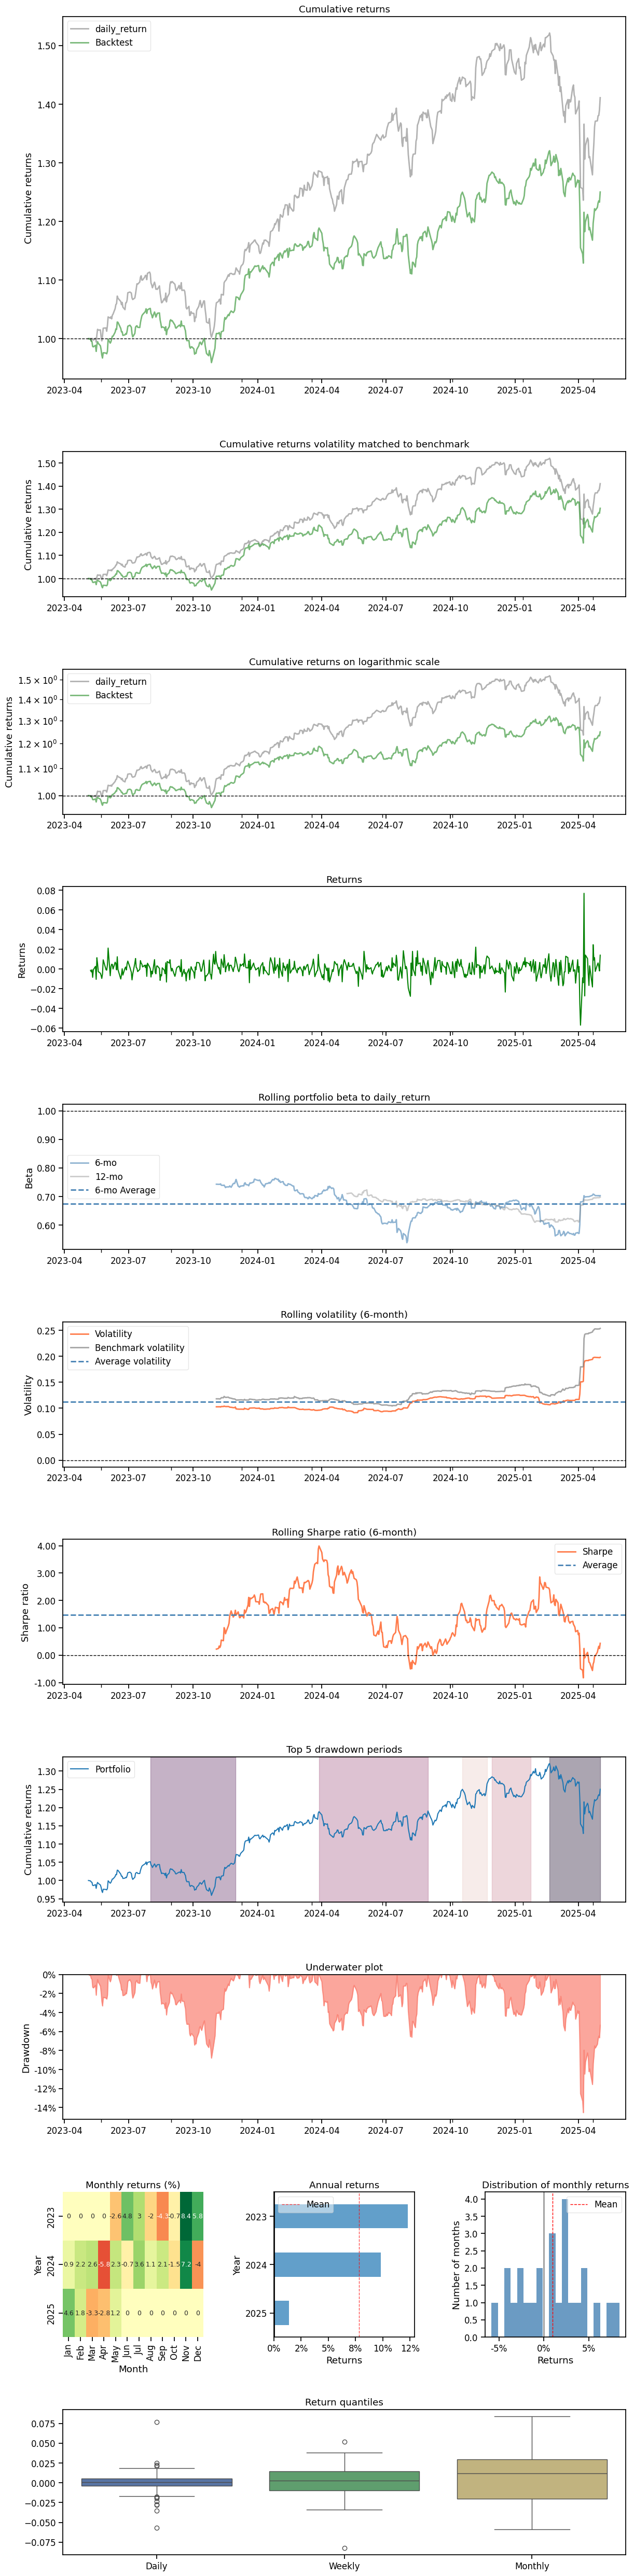

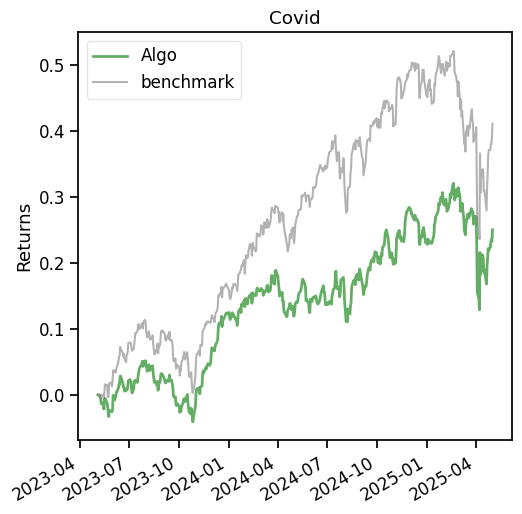

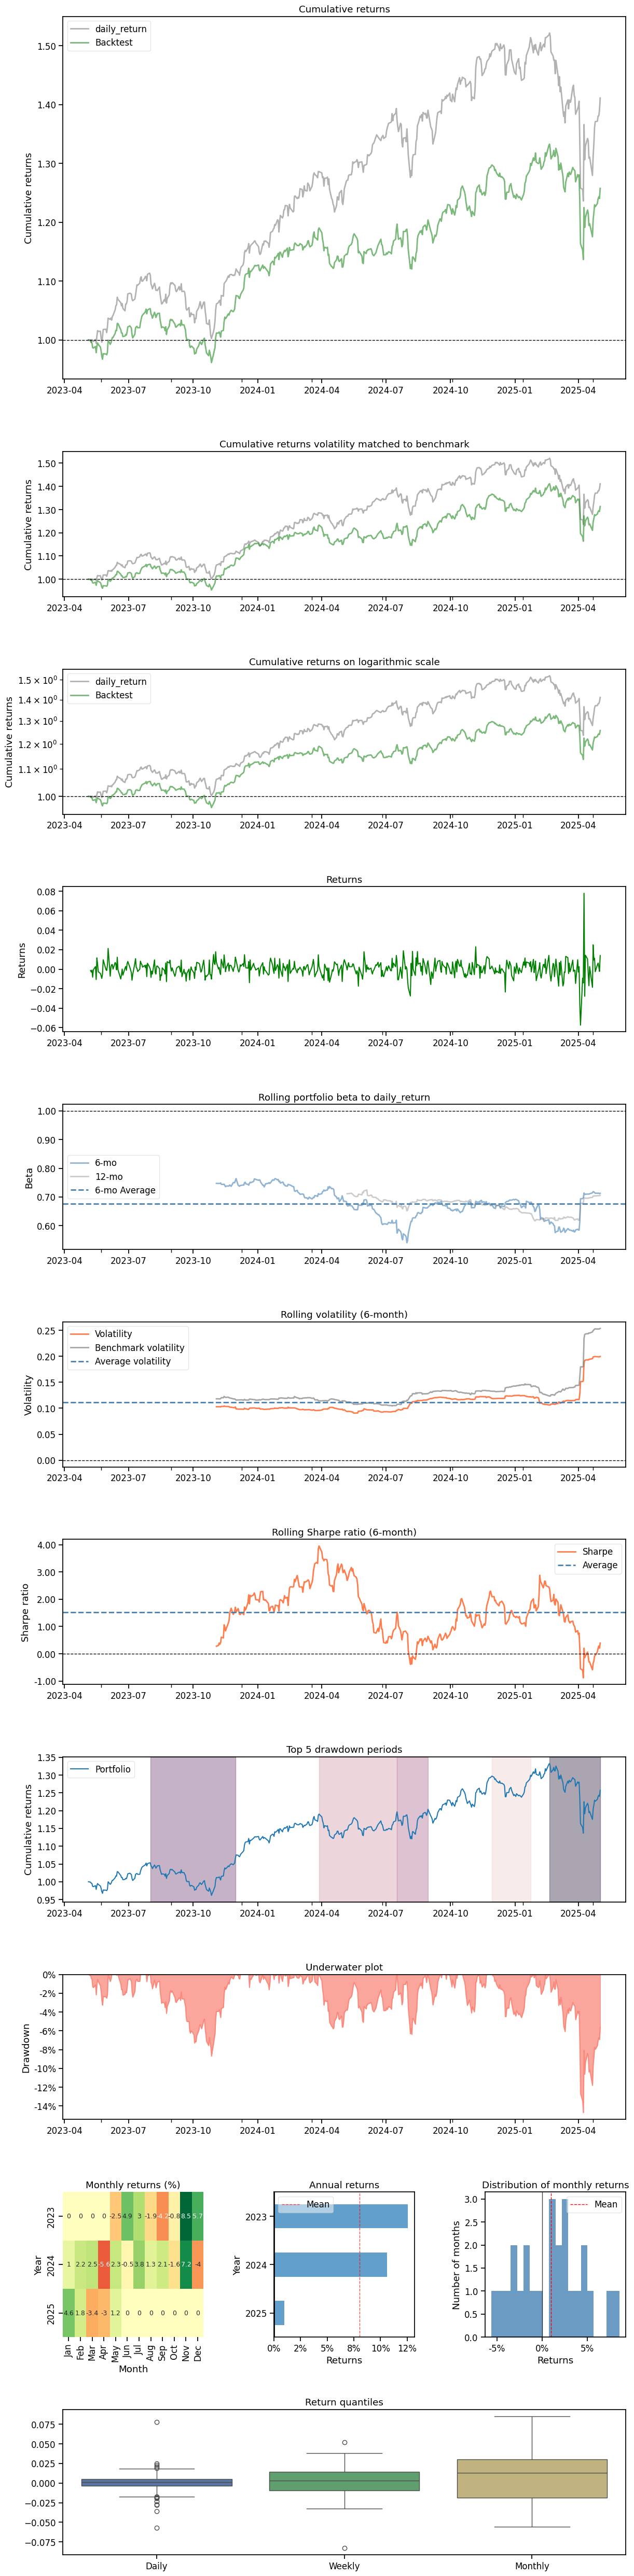

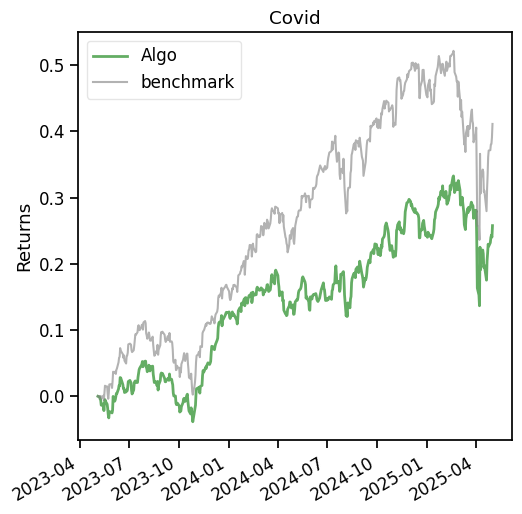

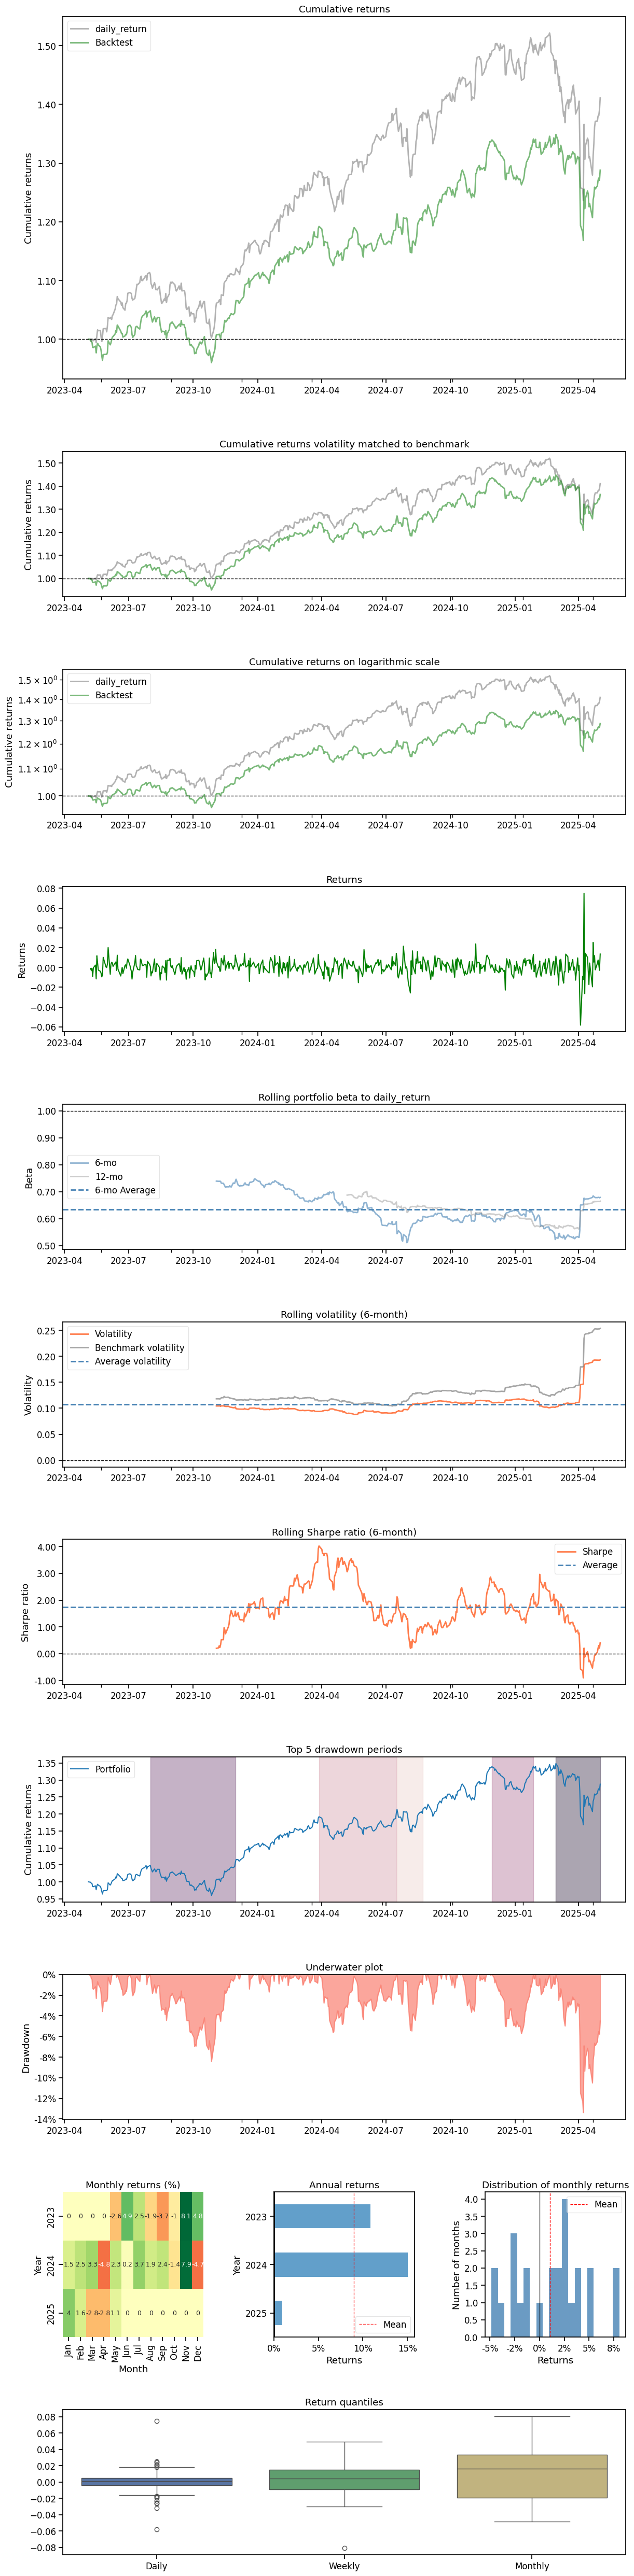

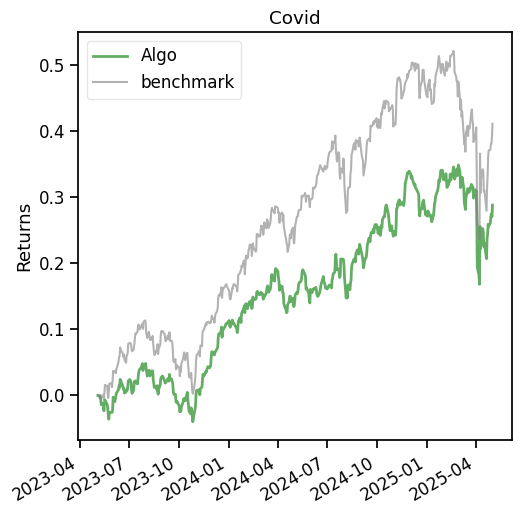

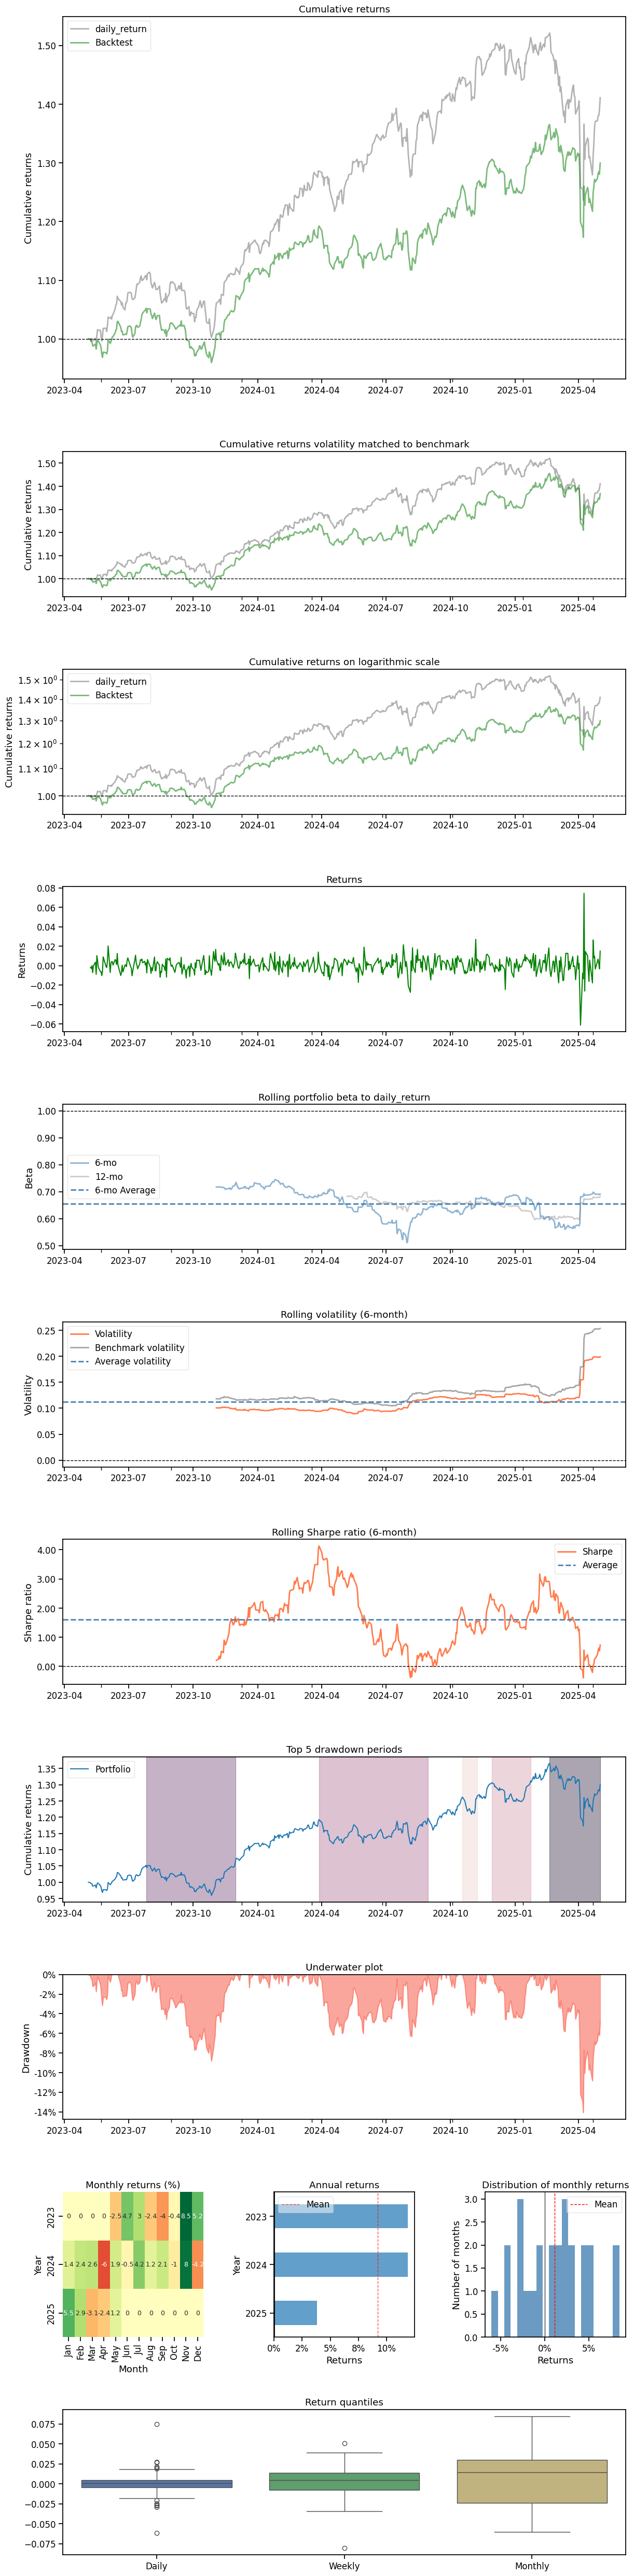

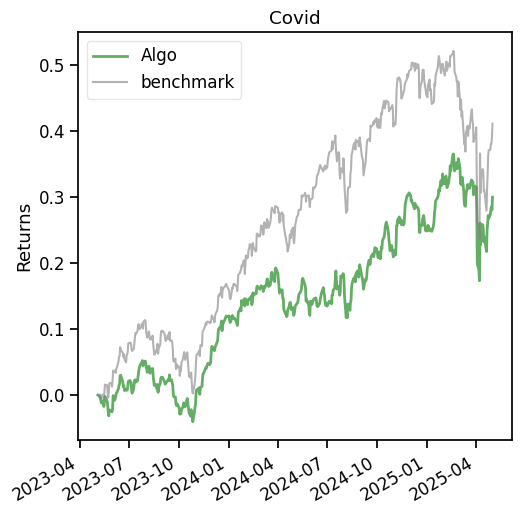

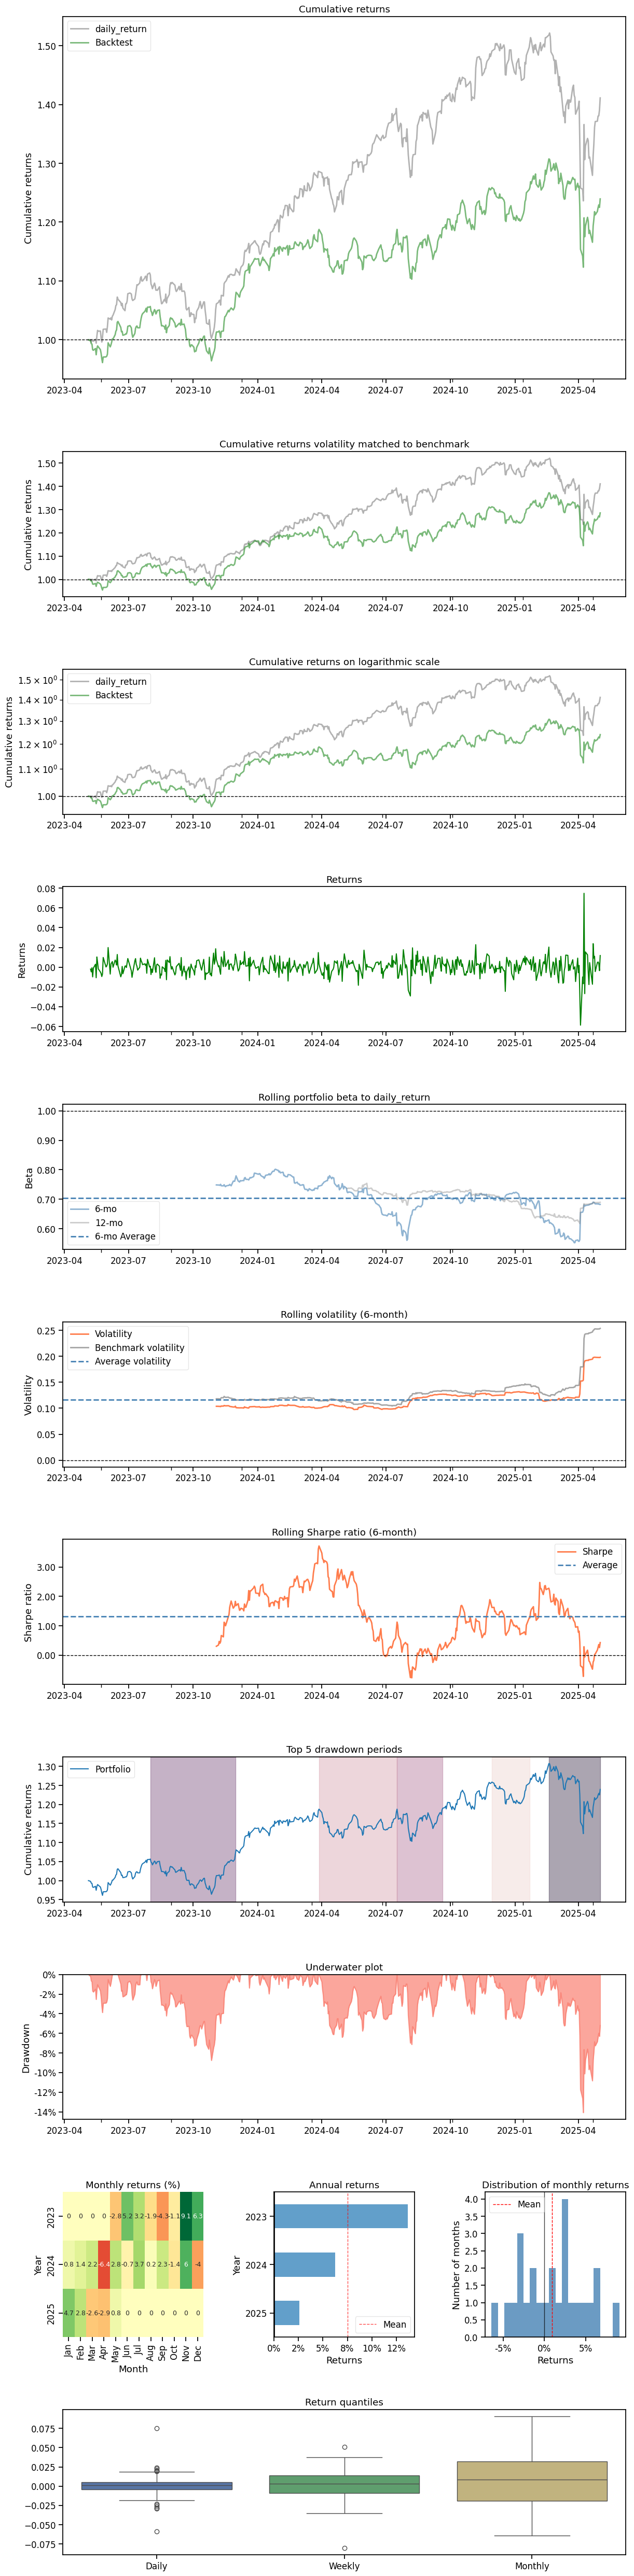

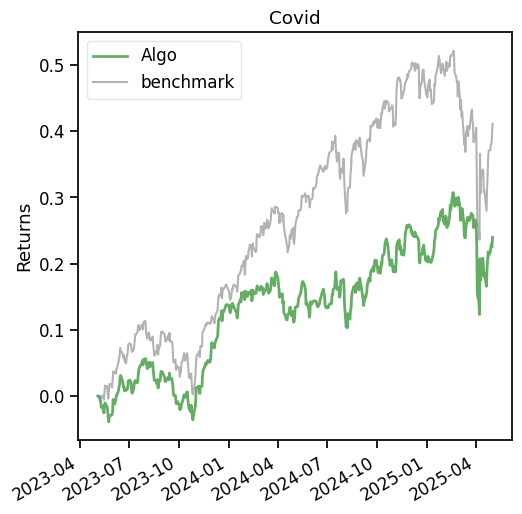

In [ ]:
def plot_backtest_results():
    for name, res in results.items():
        print(f"Plotting {name}…")
        backtest_plot(
            account_value=res["df"],
            baseline_start=test_start_date,
            baseline_end=end_date,
            baseline_ticker="SPY",
            value_col_name="account_value",
        )


plot_backtest_results()

## Benchmarks


These benchmarks will provide baseline performance metrics for comparison with the RL strategies.
We evaluate the performance of **Mean-Variance Optimization (MVO)** and simple benchmarks (**Equal-Weighted Portfolio** and **SPY**) in terms of returns, volatility, and cumulative portfolio value.


---

### Mean-Variance Optimization Benchmark

- **Objective**: Calculate the benchmark portfolio using **Mean-Variance Optimization (MVO)**.
- **Purpose**: This function benchmarks the performance of a portfolio optimized for minimum volatility using **Modern Portfolio Theory (MPT)**.
- **Comparison**: It allows us to compare the MPT strategy with other RL strategies by analyzing metrics like returns, volatility, and cumulative performance.

##### Workflow:

1. **Covariance Matrix**:

   - Extract the covariance matrix of asset returns for each trading day in the test period.
   - Use this matrix to model the relationships between asset returns.

2. **Optimization**:

   - Apply **Efficient Frontier** to minimize portfolio volatility.
   - Compute the optimal weights for each asset in the portfolio.

3. **Portfolio Value Calculation**:

   - Calculate the portfolio's account value over time using the optimized weights and asset prices.

4. **Performance Metrics**:
   - Evaluate the portfolio's performance using metrics such as annual return, cumulative return, and volatility.
   - Add the results to the `results` dictionary under the `"MPT"` key.


In [ ]:
def compute_mpt_benchmark(test, env_kwargs):
    dates_test = test.date.unique()
    min_vals = [env_kwargs["initial_amount"]]
    for i in range(len(dates_test) - 1):
        curr = test[test.date == dates_test[i]]
        nxt = test[test.date == dates_test[i + 1]]
        covm = np.array(curr.cov_list.values[0])
        ef = EfficientFrontier(None, covm, weight_bounds=(0, 1))
        ef.min_volatility()
        w = ef.clean_weights()
        prices = curr.close.values
        nextp = nxt.close.values
        shares = np.array(list(w.values())) * min_vals[-1] / prices
        min_vals.append(np.dot(shares, nextp))
    min_df = pd.DataFrame({"date": dates_test, "account_value": min_vals})
    stats_mpt = backtest_stats(min_df, value_col_name="account_value")
    return {"df": min_df, "stats": stats_mpt}


mpt_benchmark = compute_mpt_benchmark(test, env_kwargs)

Annual return          0.072452
Cumulative returns     0.148876
Annual volatility      0.110765
Sharpe ratio           0.688117
Calmar ratio           0.692140
Stability              0.846341
Max drawdown          -0.104678
Omega ratio            1.133015
Sortino ratio          0.993794
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.023863
Daily value at risk   -0.013653
dtype: float64


---

### Equal-Weighted Portfolio Benchmark

- Calculate the performance of an **equal-weighted portfolio** benchmark.
- This benchmark assumes that all assets in the portfolio are equally weighted, and their daily returns are averaged to compute the portfolio's overall return.

##### Workflow:

1. **Daily Returns Calculation**:

   - Group the test dataset by `date`.
   - Compute the percentage change (`pct_change`) in the `close` prices for each group.
   - Calculate the mean of the daily percentage changes to represent the portfolio's daily return.

2. **Cumulative Portfolio Value**:

   - Reset the index of the daily returns to create a DataFrame (`ew_df`).
   - Compute the cumulative product of the daily returns (`cumprod`) to calculate the portfolio's cumulative value over time.
   - Multiply the cumulative returns by the initial portfolio value (`initial_amount`) to get the portfolio's account value.

3. **Performance Metrics**:
   - Use the `backtest_stats` function to calculate performance metrics for the equal-weighted portfolio, such as annual return, cumulative return, and volatility.


In [ ]:
def compute_equal_weighted_benchmark(df, initial_amount=100_000):
    # Pivot to have one column per ticker
    price_wide = df.pivot_table(
        index="date", columns="tic", values="close"
    ).sort_index()

    # Compute each ticker's daily return, then average equally
    daily_rets = price_wide.pct_change().fillna(0).mean(axis=1)

    # Build the equity curve
    ew_df = pd.DataFrame({"date": daily_rets.index, "daily_return": daily_rets.values})
    ew_df["account_value"] = (ew_df["daily_return"] + 1).cumprod() * initial_amount

    # Compute performance statistics
    stats_ew = backtest_stats(ew_df, value_col_name="account_value")

    return {"df": ew_df.reset_index(drop=True), "stats": stats_ew}


ew_benchmark = compute_equal_weighted_benchmark(test, env_kwargs["initial_amount"])

Annual return          0.122459
Cumulative returns     0.257606
Annual volatility      0.135162
Sharpe ratio           0.923835
Calmar ratio           0.832995
Stability              0.864671
Max drawdown          -0.147010
Omega ratio            1.185526
Sortino ratio          1.366104
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.994491
Daily value at risk   -0.016533
dtype: float64


---

### SPY Benchmark

- **Objective**: Calculate the benchmark performance of the `SPY ETF`, which tracks the **S&P 500** index.
- **Purpose**: This function provides a baseline for comparing the performance of reinforcement learning models and other portfolio strategies.

##### Workflow:

1. **Data Retrieval**:
   - Use the `get_baseline` function to fetch the historical closing prices of the SPY ETF for the test period.
2. **Daily Returns Calculation**:
   - Compute the percentage change (`pct_change`) in the SPY closing prices to calculate daily returns.
3. **Cumulative Portfolio Value**:
   - Create a DataFrame (`spy_df`) with the daily returns and calculate the cumulative product (`cumprod`) of the daily returns to compute the portfolio's cumulative value over time.
   - Multiply the cumulative returns by the initial portfolio value (`initial_amount`) to get the portfolio's account value.
4. **Performance Metrics**:
   - Use the `backtest_stats` function to calculate performance metrics for the SPY benchmark, such as annual return, cumulative return, and volatility.


In [ ]:
def compute_spy_benchmark(test, env_kwargs):
    spy_close = get_baseline("SPY", test_start_date, end_date)["close"]
    spy_ret = spy_close.pct_change().dropna()
    spy_df = pd.DataFrame({"date": spy_ret.index, "daily_return": spy_ret.values})
    spy_df["account_value"] = (spy_df.daily_return + 1).cumprod() * env_kwargs[
        "initial_amount"
    ]
    stats_spy = backtest_stats(spy_df, value_col_name="account_value")
    return {"df": spy_df, "stats": stats_spy}


spy_benchmark = compute_spy_benchmark(test, env_kwargs)

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (500, 8)
Annual return          0.189812
Cumulative returns     0.410780
Annual volatility      0.163634
Sharpe ratio           1.145661
Calmar ratio           1.012049
Stability              0.866559
Max drawdown          -0.187552
Omega ratio            1.246933
Sortino ratio          1.704754
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.914136
Daily value at risk   -0.019872
dtype: float64


In [ ]:
benchmarks = {
    "MPT": mpt_benchmark,
    "EW": ew_benchmark,
    "SPY": spy_benchmark,
}

results.update(benchmarks)

## Performance Summary


In [ ]:
perf_stats = pd.DataFrame({key.upper(): res["stats"] for key, res in results.items()})
display(perf_stats)

A2C       PPO       SAC      DDPG       TD3  \
Annual return        0.119116  0.122464  0.136048  0.141284  0.114289   
Cumulative returns   0.250185  0.257617  0.287996  0.299801  0.239510   
Annual volatility    0.134987  0.135184  0.130929  0.134676  0.137246   
Sharpe ratio         0.902716  0.923739  1.041584  1.050560  0.858572   
Calmar ratio         0.819871  0.832612  1.016490  1.003954  0.811647   
Stability            0.854888  0.864660  0.899338  0.885257  0.833910   
Max drawdown        -0.145286 -0.147084 -0.133841 -0.140728 -0.140812   
Omega ratio          1.179972  1.185553  1.211604  1.211900  1.167165   
Sortino ratio        1.332620  1.365965  1.554443  1.560659  1.259951   
Skew                      NaN       NaN       NaN       NaN       NaN   
Kurtosis                  NaN       NaN       NaN       NaN       NaN   
Tail ratio           0.964960  0.995746  1.084021  1.063614  1.022927   
Daily value at risk -0.016523 -0.016536 -0.015954 -0.016406 -0.016824   

                          MPT        EW       SPY  
Annual return        0.072452  0.122459  0.189812  
Cumulative returns   0.148876  0.257606  0.410780  
Annual volatility    0.110765  0.135162  0.163634  
Sharpe ratio         0.688117  0.923835  1.145661  
Calmar ratio         0.692140  0.832995  1.012049  
Stability            0.846341  0.864671  0.866559  
Max drawdown        -0.104678 -0.147010 -0.187552  
Omega ratio          1.133015  1.185526  1.246933  
Sortino ratio        0.993794  1.366104  1.704754  
Skew                      NaN       NaN       NaN  
Kurtosis                  NaN       NaN       NaN  
Tail ratio           1.023863  0.994491  0.914136  
Daily value at risk -0.013653 -0.016533 -0.019872

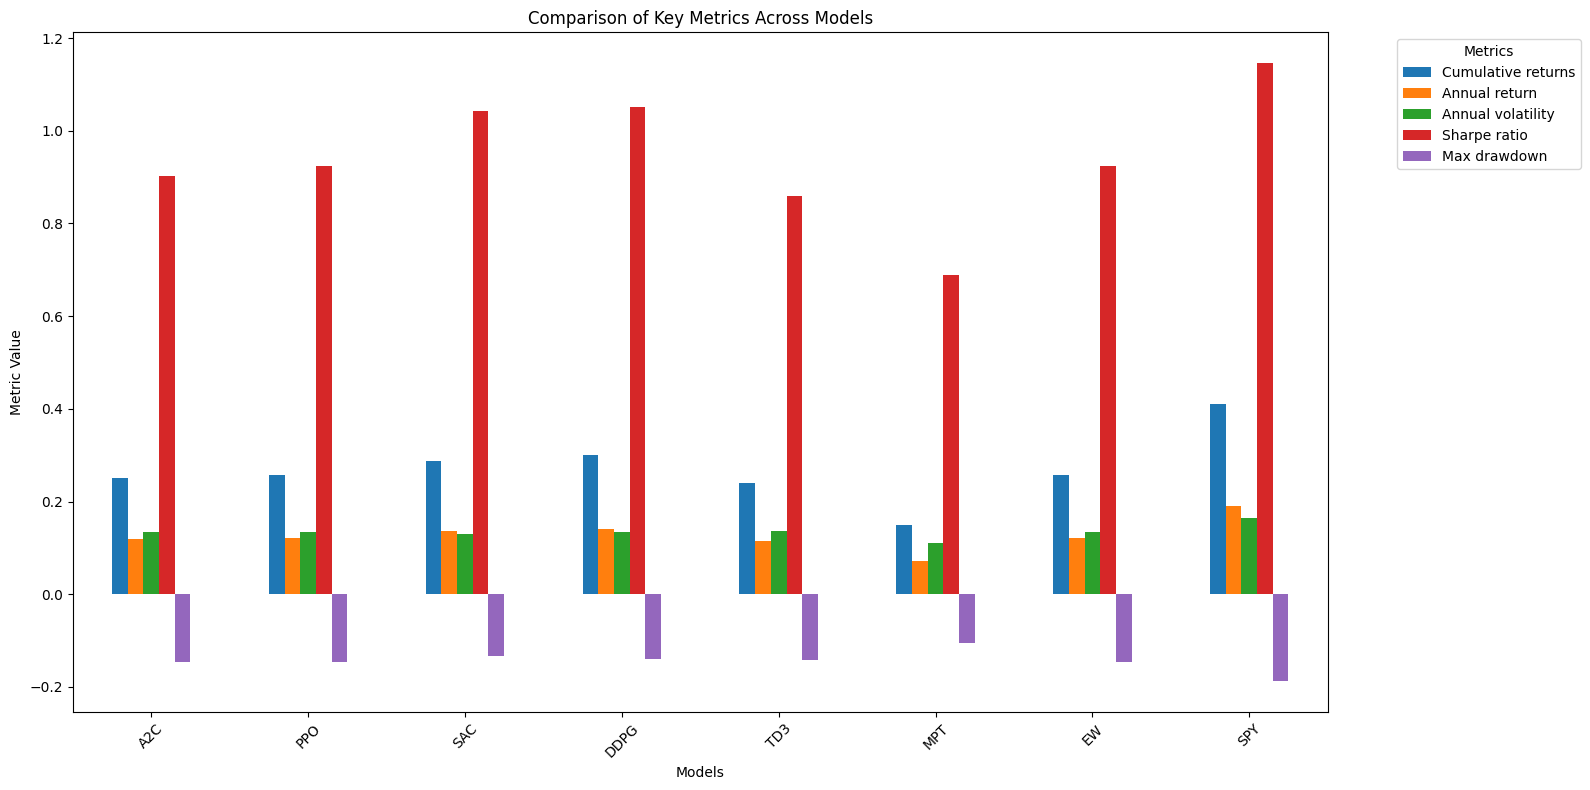

In [ ]:
comparison_metrics = [
    "Cumulative returns",
    "Annual return",
    "Annual volatility",
    "Sharpe ratio",
    "Max drawdown",
]

# Filter the performance statistics for the selected metrics
comparison_table = perf_stats.loc[comparison_metrics]


# Plot the comparison metrics as a bar chart
comparison_table.T.plot(kind="bar", figsize=(16, 8))
plt.title("Comparison of Key Metrics Across Models")
plt.ylabel("Metric Value")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Visualize the cumulative returns of various strategies over time


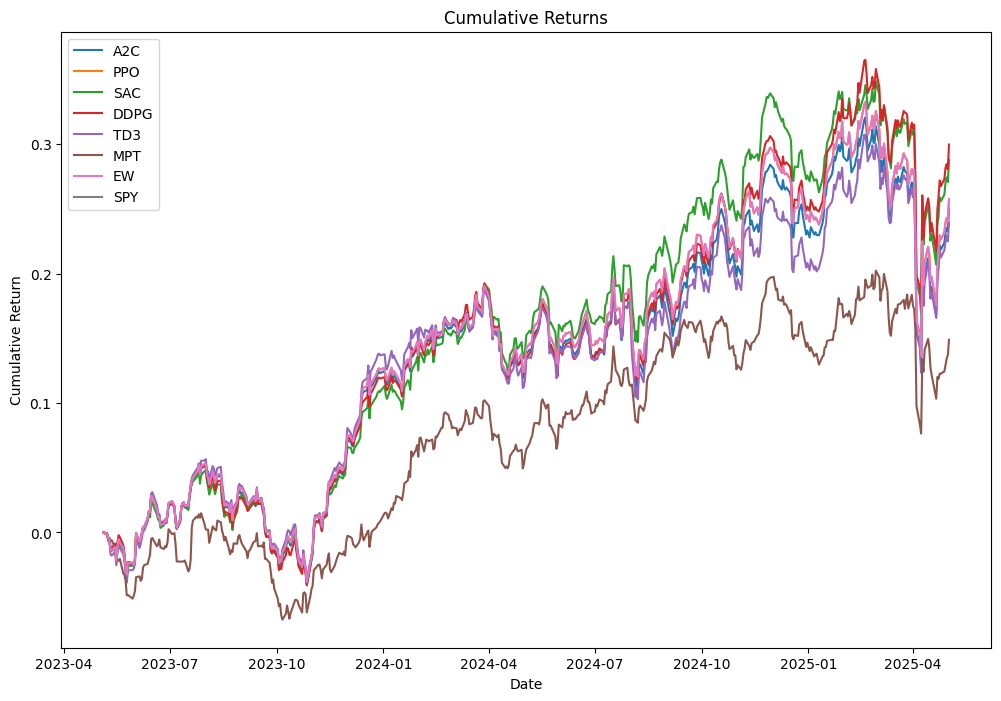

In [ ]:
def plot_cumulative_returns(results):
    plt.figure(figsize=(12, 8))
    for name, res in results.items():
        # Ensure the date column is converted to datetime
        res["df"]["date"] = pd.to_datetime(res["df"]["date"])
        # Filter data to start from the trade start date
        filtered_df = res["df"][res["df"]["date"] >= test_start_date]
        cum = (
            (filtered_df["daily_return"] + 1).cumprod() - 1
            if "daily_return" in filtered_df
            else filtered_df["account_value"] / filtered_df["account_value"].iloc[0] - 1
        )
        plt.plot(filtered_df["date"], cum, label=name)
    plt.title("Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()


plot_cumulative_returns(results)